# **Notebook 12.4: Decoding strategies**

This practical investigates neural decoding from transformer models.  

Work through the cells below, running each cell in turn. In various places you will see the words "TO DO". Follow the instructions at these places and make predictions about what is going to happen or write code to complete the functions.

Contact me at udlbookmail@gmail.com if you find any mistakes or have any suggestions.

In [ ]:
!pip install transformers

In [ ]:

from transformers import GPT2LMHeadModel, GPT2Tokenizer, set_seed
import torch
import torch.nn.functional as F
import numpy as np

In [ ]:
# Load model and tokenizer
model = GPT2LMHeadModel.from_pretrained('gpt2')
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

# Decoding from GPT2

This tutorial investigates how to use GPT2 (the forerunner of GPT3) to generate text.  There are a number of ways to do this that trade-off the realism of the text against the amount of variation.

At every stage, GPT2 takes an input string and returns a probability for each of the possible subsequent tokens.  We can choose what to do with these probability.  We could always *greedily choose* the most likely next token, or we could draw a *sample* randomly according to the probabilities.  There are also intermediate strategies such as *top-k sampling* and *nucleus sampling*, that have some controlled randomness.

We'll also investigate *beam search* -- the idea is that rather than greedily take the next best token at each stage, we maintain a set of hypotheses  (beams)as we add each subsequent token and return the most likely overall hypothesis.  This is not necessarily the same result we get from greedily choosing the next token.

First, let's investigate the token themselves.  The code below prints out the vocabulary size and shows 20 random tokens.  

In [ ]:
np.random.seed(1)
print("Number of tokens in dictionary = %d"%(tokenizer.vocab_size))
for i in range(20):
  index = np.random.randint(tokenizer.vocab_size)
  print("Token: %d "%(index)+tokenizer.decode(torch.tensor(index), skip_special_tokens=True))


Number of tokens in dictionary = 50257
Token: 33003  Mormons
Token: 12172  cam
Token: 5192  trig
Token: 32511 ojure
Token: 50057  gist
Token: 43723  Petition
Token: 7813  sin
Token: 21440  Witness
Token: 32912  Remy
Token: 20609 isure
Token: 49100  creeps
Token: 7751  fasc
Token: 43757  Alc
Token: 31228  messenger
Token: 36230  SYSTEM
Token: 32025  precipitation
Token: 21758  cores
Token: 45413  Forestry
Token: 35730  guru
Token: 8444  Disc


# Sampling

Each time we run GPT2 it will take in a set of tokens, and return a probability over each of the possible next tokens.  The simplest thing we could do is to just draw a sample from this probability distribution each time.

In [ ]:
def sample_next_token(input_tokens, model, tokenizer):
  # Run model to get prediction over next output
  outputs = model(input_ids = input_tokens['input_ids'], attention_mask = input_tokens['attention_mask'])
  # Find prediction
  prob_over_tokens = F.softmax(outputs.logits, dim=-1).detach().numpy()[0,-1]
  # print(prob_over_tokens.shape)
  # TODO Draw a random token according to the probabilities
  # next_token should be an array with an sole integer in it (as below)
  # Use:  https://numpy.org/doc/stable/reference/random/generated/numpy.random.choice.html
  # Replace this line
  next_token = np.array([np.random.choice(np.arange(prob_over_tokens.shape[0]))])
  # print(next_token)

  # Append token to sentence
  output_tokens = input_tokens
  output_tokens["input_ids"] = torch.cat((output_tokens['input_ids'],torch.tensor([next_token])),dim=1)
  output_tokens['attention_mask'] = torch.cat((output_tokens['attention_mask'],torch.tensor([[1]])),dim=1)
  output_tokens['last_token_prob'] = prob_over_tokens[next_token]

  return output_tokens

In [ ]:
# Expected output:
# "The best thing about Bath is that they don't even change or shrink anymore."

set_seed(0)
input_txt = "The best thing about Bath is"
input_tokens = tokenizer(input_txt, return_tensors='pt')
for i in range(10):
    input_tokens = sample_next_token(input_tokens, model, tokenizer)
    print(tokenizer.decode(input_tokens["input_ids"][0], skip_special_tokens=True))



<ipython-input-5-7ad7815a23bd>:16: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  output_tokens["input_ids"] = torch.cat((output_tokens['input_ids'],torch.tensor([next_token])),dim=1)


The best thing about Bath is Department
The best thing about Bath is Department favoring
The best thing about Bath is Department favoring horrendous
The best thing about Bath is Department favoring horrendous Brilliant
The best thing about Bath is Department favoring horrendous Brilliantversely
The best thing about Bath is Department favoring horrendous BrilliantverselyNic
The best thing about Bath is Department favoring horrendous BrilliantverselyNicDriver
The best thing about Bath is Department favoring horrendous BrilliantverselyNicDriverdinand
The best thing about Bath is Department favoring horrendous BrilliantverselyNicDriverdinand Yun
The best thing about Bath is Department favoring horrendous BrilliantverselyNicDriverdinand Yun Quincy


In [ ]:
# TODO Modify the code below by changing the number of tokens generated and the initial sentence
# to get a feel for how well this works.  Since I didn't reset the seed, it will give a different
# answer every time that you run it.

# TODO Experiment with changing this line:
input_txt = "The best thing about Bath is"
input_tokens = tokenizer(input_txt, return_tensors='pt')
# TODO Experiment with changing this line:
for i in range(10):
    input_tokens = sample_next_token(input_tokens, model, tokenizer)
    print(tokenizer.decode(input_tokens["input_ids"][0], skip_special_tokens=True))

The best thing about Bath is Olympics
The best thing about Bath is Olympics switching
The best thing about Bath is Olympics switching )]
The best thing about Bath is Olympics switching )] advantageous
The best thing about Bath is Olympics switching )] advantageousussy
The best thing about Bath is Olympics switching )] advantageousussythird
The best thing about Bath is Olympics switching )] advantageousussythirdubuntu
The best thing about Bath is Olympics switching )] advantageousussythirdubuntu Phase
The best thing about Bath is Olympics switching )] advantageousussythirdubuntu Phase方
The best thing about Bath is Olympics switching )] advantageousussythirdubuntu Phase方 Ahmad


# Greedy token selection

You probably (correctly) got the impression that the text from pure sampling of the probability model can be kind of random.  How about if we choose most likely token at each step?


In [ ]:
def get_best_next_token(input_tokens, model, tokenizer):
  # Run model to get prediction over next output
  outputs = model(input_ids = input_tokens['input_ids'], attention_mask = input_tokens['attention_mask'])
  # Find prediction
  prob_over_tokens = F.softmax(outputs.logits, dim=-1).detach().numpy()[0,-1]

  # TODO -- find the token index with the maximum probability
  # It should be returns as a list (i.e., put squared brackets around it)
  # Use https://numpy.org/doc/stable/reference/generated/numpy.argmax.html
  # Replace this line
  next_token = np.array([np.argmax(prob_over_tokens)])


  # Append token to sentence
  output_tokens = input_tokens
  output_tokens["input_ids"] = torch.cat((output_tokens['input_ids'],torch.tensor([next_token])),dim=1)
  output_tokens['attention_mask'] = torch.cat((output_tokens['attention_mask'],torch.tensor([[1]])),dim=1)
  output_tokens['last_token_prob'] = prob_over_tokens[next_token]
  return output_tokens

In [ ]:
# Expected output:
# The best thing about Bath is that it's a place where you can go to
set_seed(0)
input_txt = "The best thing about Bath is"
input_tokens = tokenizer(input_txt, return_tensors='pt')
for i in range(10):
    input_tokens = get_best_next_token(input_tokens, model, tokenizer)
    print(tokenizer.decode(input_tokens["input_ids"][0], skip_special_tokens=True))

The best thing about Bath is that
The best thing about Bath is that it
The best thing about Bath is that it's
The best thing about Bath is that it's a
The best thing about Bath is that it's a place
The best thing about Bath is that it's a place where
The best thing about Bath is that it's a place where you
The best thing about Bath is that it's a place where you can
The best thing about Bath is that it's a place where you can go
The best thing about Bath is that it's a place where you can go to


In [ ]:
# TODO Modify the code below by changing the number of tokens generated and the initial sentence
# to get a feel for how well this works.

# TODO Experiment with changing this line:
input_txt = "I need to fart"
input_tokens = tokenizer(input_txt, return_tensors='pt')
# TODO Experiment with changing this line:
for i in range(10):
    input_tokens = get_best_next_token(input_tokens, model, tokenizer)
    print(tokenizer.decode(input_tokens["input_ids"][0], skip_special_tokens=True))

I need to fart.
I need to fart. I
I need to fart. I need
I need to fart. I need to
I need to fart. I need to fart
I need to fart. I need to fart.
I need to fart. I need to fart. I
I need to fart. I need to fart. I need
I need to fart. I need to fart. I need to
I need to fart. I need to fart. I need to fart


# Top-K sampling

You probably noticed that the greedy strategy produces quite realistic text, but it's kind of boring.  It produces generic answers.  Also, if this was a chatbot, then we wouldn't necessarily want it to produce the same answer to a question each time.  

Top-K sampling is a compromise strategy that samples randomly from the top K most probable tokens.  We could just choose them with a uniform distribution, or (as here) we could sample them according to their original probabilities.

In [ ]:
def get_top_k_token(input_tokens, model, tokenizer, k=20):
  # Run model to get prediction over next output
  outputs = model(input_ids = input_tokens['input_ids'], attention_mask = input_tokens['attention_mask'])
  # Find prediction
  prob_over_tokens = F.softmax(outputs.logits, dim=-1).detach().numpy()[0,-1] #== getting logits from the last word with a batch size of 1

  # Draw a sample from the top K most likely tokens.
  # Take copy of the probabilities and sort from largest to smallest (use np.sort)
  # TODO -- replace this line
  sorted_prob_over_tokens =  -np.sort(-prob_over_tokens, axis = 0)

  # Find the probability at the k'th position
  # TODO -- replace this line
  kth_prob_value = sorted_prob_over_tokens[k]

  # Set all probabilities below this value to zero
  prob_over_tokens[prob_over_tokens<kth_prob_value] = 0


  # Renormalize the probabilities so that they sum to one
  # TODO -- replace this line
  prob_over_tokens = prob_over_tokens/np.sum(prob_over_tokens)

  # Draw random token
  next_token = np.random.choice(len(prob_over_tokens), 1, replace=False, p=prob_over_tokens)

  # Append token to sentence
  output_tokens = input_tokens
  output_tokens["input_ids"] = torch.cat((output_tokens['input_ids'],torch.tensor([next_token])),dim=1)
  output_tokens['attention_mask'] = torch.cat((output_tokens['attention_mask'],torch.tensor([[1]])),dim=1)
  output_tokens['last_token_prob'] = prob_over_tokens[next_token]
  return output_tokens

In [ ]:
# Expected output:
# The best thing about Bath is that you get to see all the beautiful faces of

set_seed(0)
input_txt = "The best thing about Bath is"
input_tokens = tokenizer(input_txt, return_tensors='pt')
for i in range(10):
    input_tokens = get_top_k_token(input_tokens, model, tokenizer, k=10)
    print(tokenizer.decode(input_tokens["input_ids"][0], skip_special_tokens=True))

The best thing about Bath is that
The best thing about Bath is that you
The best thing about Bath is that you get
The best thing about Bath is that you get to
The best thing about Bath is that you get to see
The best thing about Bath is that you get to see all
The best thing about Bath is that you get to see all the
The best thing about Bath is that you get to see all the beautiful
The best thing about Bath is that you get to see all the beautiful faces
The best thing about Bath is that you get to see all the beautiful faces of


In [131]:
# TODO
# Experiment with different values of k
# If you set it to a lower number (say 3) the text will be less random
# If you set it to a higher number (say 5000) the text will be more random

# set_seed(0)
input_txt = "I am a scary guy"
input_tokens = tokenizer(input_txt, return_tensors='pt')
full = input_tokens["input_ids"]
for i in range(100):
    input_tokens = get_top_k_token(input_tokens, model, tokenizer, k=10)
    full = torch.cat((full, torch.tensor([[input_tokens["input_ids"][0, -1]]])), dim = 1)
    if i % 10 == 0 and i != 0:
      print(tokenizer.decode(full[0, i-10: full[0].shape[0]], skip_special_tokens=True))
# print(tokenizer.decode(input_tokens["input_ids"][0], skip_special_tokens=True))

I am a scary guy and if I am not, it will come. I
, it will come. I have to be more careful of myself. If I
 careful of myself. If I am in the right situation it is okay and I
 situation it is okay and I don't need to say I am afraid or I
 say I am afraid or I am afraid of something, but I don't need
, but I don't need to feel like the situation is going to change."
 situation is going to change."

The incident comes on the heels of a
 comes on the heels of a series of high-profile police shootings in California.
profile police shootings in California. In January 2015, two officers in Oakland were killed


In [122]:
full, input_tokens["input_ids"][0, -1]

(tensor([[   40,   716,   257, 14343,  3516]]), tensor(11))

In [130]:
print(tokenizer.decode(full[0], skip_special_tokens=True))

I am a scary guy, but if it wasn't for my mother, she would've been dead in my room!"


A few days later, he was back in jail. He was still living in a tent on the outskirts of the city, in a house that had been rented out to a friend and he was still getting ready to get out of the house when the police arrived.


"The next day, I had no idea what had happened," he says. "I thought that my father and his


# Nucleus sampling

Top-K sampling has the disadvantage that sometimes there are only a few plausible next tokens, and sometimes there are a lot.  How do we adapt to this situation?  One way is to sample from a fixed proportion of the probability mass.  That is we order the tokens in terms of probability and cut off the possibility of sampling when the cumulative sum is greater than a threshold.

This way, we adapt the number of possible tokens that we can choose.

In [ ]:
def get_nucleus_sampling_token(input_tokens, model, tokenizer, thresh=0.25):
  # Run model to get prediction over next output
  outputs = model(input_ids = input_tokens['input_ids'], attention_mask = input_tokens['attention_mask'])
  # Find prediction
  prob_over_tokens = F.softmax(outputs.logits, dim=-1).detach().numpy()[0,-1]

  # Find the most likely tokens that make up the first (thresh) of the probability
  # TODO -- sort the probabilities in decreasing order
  # Replace this line
  sorted_probs_decreasing = -np.sort(-prob_over_tokens)

  # TODO -- compute the cumulative sum of these probabilities
  # Replace this line
  cum_sum_probs = np.cumsum(sorted_probs_decreasing)


  # Find index where that the cumulative sum is greater than the threshold
  thresh_index = np.argmax(cum_sum_probs>thresh)
  print("Choosing from %d tokens"%(thresh_index))
  # TODO:  Find the probability value to threshold
  # Replace this line:
  thresh_prob = sorted_probs_decreasing[thresh_index]

  # Set any probabilities less than this to zero
  prob_over_tokens[prob_over_tokens<thresh_prob] = 0
  # Renormalize
  prob_over_tokens = prob_over_tokens / np.sum(prob_over_tokens)
  # Draw random token
  next_token = np.random.choice(len(prob_over_tokens), 1, replace=False, p=prob_over_tokens)

  # Append token to sentence
  output_tokens = input_tokens
  output_tokens["input_ids"] = torch.cat((output_tokens['input_ids'],torch.tensor([next_token])),dim=1)
  output_tokens['attention_mask'] = torch.cat((output_tokens['attention_mask'],torch.tensor([[1]])),dim=1)
  output_tokens['last_token_prob'] = prob_over_tokens[next_token]
  output_tokens['allProbs'] = prob_over_tokens
  return output_tokens

In [ ]:
# Expected output:
# The best thing about Bath is that it's not a city that has been around
set_seed(0)
input_txt = "The best thing about Bath is"
input_tokens = tokenizer(input_txt, return_tensors='pt')
for i in range(10):
    input_tokens = get_nucleus_sampling_token(input_tokens, model, tokenizer, thresh = 0.2)
    print(tokenizer.decode(input_tokens["input_ids"][0], skip_special_tokens=True))


In [ ]:
# TODO -- experiment with setting the threshold probability to larger or smaller values
input_txt = "I am the chief executive officer of a shit factory"
input_tokens = tokenizer(input_txt, return_tensors='pt')
for i in range(50):
    input_tokens = get_nucleus_sampling_token(input_tokens, model, tokenizer, thresh = 0.2)
    print(tokenizer.decode(input_tokens["input_ids"][0], skip_special_tokens=True))

# Beam search

All of the methods we've seen so far choose the tokens one by one.  But this isn't necessarily sensible.  Even greedily choosing the best token doesn't necessarily retrieve the sequence with the highest probability.  It might be that the most likely token only has very unlikely tokens following it.

Beam search maintains $K$ hypotheses about the best possible continuation.  It starts with the top $K$ continuations.  Then for each of those, it finds the top K continuations, giving $K^2$ hypotheses.  Then it retains just the top $K$ of these so that the number of hypotheses stays the same.

In [ ]:
# This routine returns the k'th most likely next token.
# If k =0 then it returns the most likely token, if k=1 it returns the next most likely and so on
# We will need this for beam search
def get_kth_most_likely_token(input_tokens, model, tokenizer, k):
  # Run model to get prediction over next output
  outputs = model(input_ids = input_tokens['input_ids'], attention_mask = input_tokens['attention_mask'])
  # Find prediction
  prob_over_tokens = F.softmax(outputs.logits, dim=-1).detach().numpy()[0,-1]

  # Find the k'th most likely token
  # TODO Sort the probabilities from largest to smallest
  # Replace this line:
  sorted_prob_over_tokens = -np.sort(-prob_over_tokens)
  # TODO Find the k'th sorted probability
  # Replace this line
  kth_prob_value = sorted_prob_over_tokens[k]



  # Find position of this token.
  next_token = np.where(prob_over_tokens == kth_prob_value)[0]

  # Append token to sentence
  output_tokens = input_tokens
  output_tokens["input_ids"] = torch.cat((output_tokens['input_ids'],torch.tensor([next_token])),dim=1)
  output_tokens['attention_mask'] = torch.cat((output_tokens['attention_mask'],torch.tensor([[1]])),dim=1)
  output_tokens['last_token_prob'] = prob_over_tokens[next_token]
  output_tokens['log_prob'] = output_tokens['log_prob'] + np.log(prob_over_tokens[next_token])
  return output_tokens

In [ ]:
# We can test this code and see that if we choose the 2nd most likely (K=1) token each time
# then we get much better generation results than if we choose the 2001st most likely token

# Expected output:
# The best thing about Bath is the way you get the most bang outta the
set_seed(0)
input_txt = "The best thing about Bath is"
input_tokens = tokenizer(input_txt, return_tensors='pt')
input_tokens['log_prob'] = 0.0
for i in range(10):
    input_tokens = get_kth_most_likely_token(input_tokens, model, tokenizer, k=1)
    print(tokenizer.decode(input_tokens["input_ids"][0], skip_special_tokens=True))

# Expected output:
# The best thing about Bath is mixed profits partnerships» buy generic+ Honda throttlecont
input_txt = "The best thing about Bath is"
input_tokens = tokenizer(input_txt, return_tensors='pt')
input_tokens['log_prob'] = 0.0
for i in range(10):
    input_tokens = get_kth_most_likely_token(input_tokens, model, tokenizer, k=2000)
    print(tokenizer.decode(input_tokens["input_ids"][0], skip_special_tokens=True))

# TODO -- play around with different values of K

In [21]:
# Print out each beam plus the log probability
def print_beams(beams):
  for index,beam in enumerate(beams):
    print("Beam %d, Prob %3.3f: "%(index,beam['log_prob'])+tokenizer.decode(beam["input_ids"][0], skip_special_tokens=True))
  print('---')


# TODO:  Read this code carefully!
def do_beam_search(input_tokens_in, model, tokenizer, n_beam=5, beam_length=10):
  # Store beams in a list
  input_tokens['log_prob'] = 0.0

  # Initialize with n_beam most likely continuations
  beams = [None] * n_beam
  for c_k in range(n_beam):
    beams[c_k] = dict(input_tokens_in)
    beams[c_k] = get_kth_most_likely_token(beams[c_k], model, tokenizer, c_k)

  print_beams(beams)

  # For each token in the sequence we will add
  for c_pos in range(beam_length-1):
    # Now for each beam, we continue it in the most likely ways, making n_beam*n_beam type hypotheses
    beams_all = [None] * (n_beam*n_beam)
    log_probs_all = np.zeros(n_beam*n_beam)
    # For each current hypothesis
    for c_beam in range(n_beam):
      # For each continuation
      for c_k in range(n_beam):
        # Store the continuation and the probability
        beams_all[c_beam * n_beam + c_k] = dict(get_kth_most_likely_token(beams[c_beam], model, tokenizer, c_k))
        log_probs_all[c_beam * n_beam + c_k] = beams_all[c_beam * n_beam + c_k]['log_prob']

    # Keep the best n_beams sequences with the highest probabilities
    sorted_index = np.argsort(np.array(log_probs_all)*-1)
    for c_k in range(n_beam):
      beams[c_k] = dict(beams_all[sorted_index[c_k]])

    # Print the beams
    print_beams(beams)

  return beams[0]

In [ ]:
# Expected output:
# The best thing about Bath is that it's a place where you don't have to

set_seed(0)
input_txt = "The best thing about Bath is"
input_tokens = tokenizer(input_txt, return_tensors='pt')

# Now let's call the beam search
# It takes a while as it has to run the model multiple times to add a token
n_beams = 5
best_beam = do_beam_search(input_tokens,model,tokenizer)
print("Beam search result:")
print(tokenizer.decode(best_beam["input_ids"][0], skip_special_tokens=True))

# You should see that the best answer is not the same as the greedy solution we found above


In [23]:
def get_nucleus_sampling_token(input_tokens, model, tokenizer, thresh=0.25):
  # Run model to get prediction over next output
  outputs = model(input_ids = input_tokens['input_ids'], attention_mask = input_tokens['attention_mask'])
  # Find prediction
  prob_over_tokens = F.softmax(outputs.logits, dim=-1).detach().numpy()[0,-1]

  # Find the most likely tokens that make up the first (thresh) of the probability
  # TODO -- sort the probabilities in decreasing order
  # Replace this line
  sorted_probs_decreasing = -np.sort(-prob_over_tokens)

  # TODO -- compute the cumulative sum of these probabilities
  # Replace this line
  cum_sum_probs = np.cumsum(sorted_probs_decreasing)


  # Find index where that the cumulative sum is greater than the threshold
  thresh_index = np.argmax(cum_sum_probs>thresh)
  print("Choosing from %d tokens"%(thresh_index))
  # TODO:  Find the probability value to threshold
  # Replace this line:
  thresh_prob = sorted_probs_decreasing[thresh_index]

  # Set any probabilities less than this to zero
  prob_over_tokens[prob_over_tokens<thresh_prob] = 0
  # Renormalize
  prob_over_tokens = prob_over_tokens / np.sum(prob_over_tokens)
  # Draw random token
  next_token = np.random.choice(len(prob_over_tokens), 1, replace=False, p=prob_over_tokens)

  # Append token to sentence
  output_tokens = input_tokens
  output_tokens["input_ids"] = torch.cat((output_tokens['input_ids'],torch.tensor([next_token])),dim=1)
  output_tokens['attention_mask'] = torch.cat((output_tokens['attention_mask'],torch.tensor([[1]])),dim=1)
  output_tokens['last_token_prob'] = prob_over_tokens[next_token]
  output_tokens['allProbs'] = prob_over_tokens
  return output_tokens

In [79]:
# for i in range(input_tokens['input_ids'][0].shape[0]):
input_txt = "A large language model is a modelling technique"
continuedWriting = " to perform language-based tasks in an automated way. It can be used for translation, text generation etc."
input_tokens = tokenizer(input_txt, return_tensors='pt')
continuedTokens = tokenizer(input_txt + continuedWriting, return_tensors='pt')
continuedTokens2 = tokenizer(input_txt + continuedWriting, return_tensors='pt')
originalContextLength = input_tokens['input_ids'][0].shape[0]
probsMachineGenerated = []
probsHumanWritten = []
probsHumanWritten2 =[] #for inputting whole sequence and seeing only 1 word

for i in range(continuedTokens["input_ids"].shape[1] - originalContextLength -1):
  # print(input_tokens['input_ids'][0,i])
  input_tokens = get_nucleus_sampling_token(input_tokens, model, tokenizer, thresh = 0.2)
  # print(i, originalContextLength, continuedTokens2["input_ids"][:, :originalContextLength+ i].shape)
  continuedTokens2["input_ids"] = continuedTokens["input_ids"][:, :originalContextLength + i]
  continuedTokens2['attention_mask'] = torch.ones((1, originalContextLength + i))

  # continuedTokensOut = get_nucleus_sampling_token(continuedTokens2, model, tokenizer, thresh = 0.2)
  continuedTokensOut = get_nucleus_sampling_token(continuedTokens2, model, tokenizer, thresh = 0.2)

  # probsMachineGenerated.append(input_tokens['last_token_prob'][0]) # for the case where only initial sequence is measured
  probsMachineGenerated.append(continuedTokensOut['last_token_prob'][0]) # for the case where human written sequence is fed, but only next words are compared
  probsHumanWritten.append(continuedTokensOut['allProbs'][continuedTokens["input_ids"][0,originalContextLength + i]])
  probsHumanWritten2.append(input_tokens['allProbs'][continuedTokens["input_ids"][0,i]])

  # print(tokenizer.decode(continuedTokensOut["input_ids"][0], skip_special_tokens=True), continuedTokensOut['last_token_prob'][0], continuedTokensOut['allProbs'][continuedTokens["input_ids"][0,originalContextLength + i]])
  # print('=====human written==========', tokenizer.decode(continuedTokens["input_ids"][0,originalContextLength + i], skip_special_tokens=True))


Choosing from 0 tokens
Choosing from 0 tokens
Choosing from 2 tokens
Choosing from 6 tokens
Choosing from 1 tokens
Choosing from 2 tokens
Choosing from 1 tokens
Choosing from 1 tokens
Choosing from 5 tokens
Choosing from 0 tokens
Choosing from 0 tokens
Choosing from 6 tokens
Choosing from 11 tokens
Choosing from 0 tokens
Choosing from 0 tokens
Choosing from 0 tokens
Choosing from 3 tokens
Choosing from 5 tokens
Choosing from 1 tokens
Choosing from 0 tokens
Choosing from 10 tokens
Choosing from 0 tokens
Choosing from 0 tokens
Choosing from 1 tokens
Choosing from 0 tokens
Choosing from 0 tokens
Choosing from 0 tokens
Choosing from 0 tokens
Choosing from 0 tokens
Choosing from 0 tokens
Choosing from 1 tokens
Choosing from 0 tokens
Choosing from 4 tokens
Choosing from 7 tokens
Choosing from 0 tokens
Choosing from 0 tokens
Choosing from 0 tokens
Choosing from 7 tokens
Choosing from 1 tokens
Choosing from 1 tokens
Choosing from 7 tokens
Choosing from 0 tokens


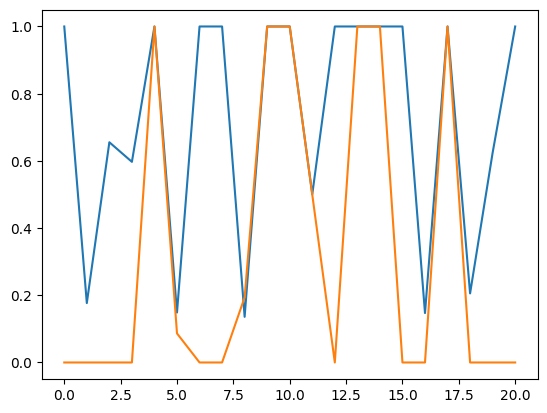

In [80]:
import matplotlib.pyplot as plt

plt.plot(range(len(probsMachineGenerated)), probsMachineGenerated)
plt.plot(range(len(probsHumanWritten)), probsHumanWritten)

You can read about more decoding strategies in this blog (which uses a recursive neural network, not a transformer, but the principles are the same).

https://www.borealisai.com/research-blogs/tutorial-6-neural-natural-language-generation-decoding-algorithms/

You can also look at other possible language models via hugging face:

https://huggingface.co/docs/transformers/v4.25.1/en/model_summary#decoders-or-autoregressive-models
